In [26]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]

font = {'size'   : 20, }
axes = {'labelsize': 'large', 'titlesize': 'large'}

mpl.rc('font', **font)
mpl.rc('axes', **axes)

import pandas as pd
import data_utils
import matplotlib.style as style


In [29]:
# Paths to data csvs
wd = "/home/behzad/Documents/barnes_lab/cplusplus_software/speed_test/repressilator/cpp"
data_dir = wd + "/output/two_species_stable_6/Population_0"
distances_path = data_dir + "/distances.csv"
eigenvalues_path = data_dir + "/eigenvalues_do_fsolve_state.csv"
model_space_report_path = data_dir + "/model_space_report.csv"
adj_mat_dir = "/home/behzad/Documents/barnes_lab/sympy_consortium_framework/output/two_species_no_symm/adj_matricies/model_#REF#_adj_mat.csv"
output_dir = wd + "/data_analysis_notebook/figures/figure1_parts/"

In [30]:
# Load dataframes
distances_df = pd.read_csv(distances_path)
eigenvalues_df = pd.read_csv(eigenvalues_path)
model_space_report_df = pd.read_csv(model_space_report_path)

# Make distances numeric
distances_df = data_utils.distances_pre_processing(distances_df)

In [31]:
# Join eigenvalues and distances on the simulation index, batch number and model_ref

all_neg_eig = data_utils.all_negative_eigs(eigenvalues_df)
all_real_eig = data_utils.all_real_eigs(eigenvalues_df)
all_zero_eig = data_utils.all_zero_eigs(eigenvalues_df)

eigenvalues_df['all_neg_eig'] = all_neg_eig
eigenvalues_df['all_real_eig'] = all_real_eig
eigenvalues_df['all_zero_eig'] = all_zero_eig

positive_loops, negative_loops = data_utils.make_feedback_loop_counts(model_space_report_df, adj_mat_dir)
total_num_parts, num_AHL_parts, num_microcin_parts = data_utils.make_num_parts(model_space_report_df, 
                                                                               adj_mat_dir)
model_space_report_df['pos_loop_count'] = positive_loops
model_space_report_df['neg_loop_count'] = negative_loops
model_space_report_df['total_num_parts'] = num_parts

loop_ratios = []
for x, y in zip(negative_loops, positive_loops):
    try:
        loop_ratios.append(x/y)
    
    except(ZeroDivisionError):
        loop_ratios.append(np.nan)
        
    
model_space_report_df['loop_count_ratio'] = loop_ratios

Index(['eig_0_real', 'eig_1_real', 'eig_2_real', 'eig_3_real', 'eig_4_real',
       'eig_5_real', 'eig_6_real', 'eig_7_real', 'eig_8_real', 'eig_9_real'],
      dtype='object')


In [32]:
joint_df = pd.merge(left=eigenvalues_df, right=distances_df, how='inner', on=['sim_idx', 'batch_num', 'model_ref'])
joint_df.reset_index()

# joint_df['sum_std'] = joint_df['d2'] + joint_df['d5']
# # Set accepted or rejected particles
# mask = (joint_df['d1'] == 0) & (joint_df['d2'] < 100) & (joint_df['d3'] > 1e4) & (joint_df['d4'] == 0) & (joint_df['d5'] < 100) & (joint_df['d6'] > 1e4)
# joint_df.loc[mask, 'Accepted'] = True
# joint_df.loc[~mask, 'Accepted'] = False

,index,sim_idx,batch_num,model_ref,integ_error,fsolve_error,eig_0_real,eig_0_imag,eig_1_real,eig_1_imag,...,all_neg_eig,all_real_eig,all_zero_eig,Accepted,d1,d2,d3,d4,d5,d6
0,0,0,0,114,species_decayed,5,1.247208e+00,0.000000,2.561869e+00,0.000000,...,False,False,False,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308
1,1,1,0,2,species_decayed,1,-7.898492e-01,0.000000,-5.372419e+05,0.000000,...,True,False,False,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308
2,2,2,0,100,NaN,1,-2.869929e+04,0.000000,-1.347403e+00,0.000000,...,True,False,False,True,0.000000e+00,1.192093e-06,1.803211e+09,0.000000e+00,1.342773e-03,9.958175e+11
3,3,3,0,1,NaN,1,-2.045571e+02,0.000000,-2.736584e-01,0.000000,...,True,True,False,False,4.158591e-123,1.142648e-111,1.321177e-122,0.000000e+00,1.037598e-03,5.436498e+11
4,4,4,0,81,species_decayed,1,-5.320575e+06,0.000000,-3.438436e-01,0.000000,...,True,True,False,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308
5,5,5,0,7,NaN,5,-3.766379e+04,0.000000,6.887892e-01,0.000000,...,False,True,False,False,1.652850e+06,3.208747e+06,2.834563e+06,1.737671e+06,1.102055e+07,3.999986e+12
6,6,6,0,83,species_decayed,5,2.521864e+00,0.000000,9.279987e-01,0.000000,...,False,True,False,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308
7,7,7,0,102,species_decayed,5,1.250300e+00,0.000000,-9.975415e-01,0.425756,...,False,False,False,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308
8,8,8,0,11,species_decayed,1,NaN,0.000000,NaN,0.000000,...,True,True,True,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308
9,9,9,0,26,species_decayed,1,-3.049621e-02,0.358858,-3.049621e-02,-0.358858,...,True,False,False,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308


In [34]:
print(model_space_report_df.columns)
model_space_idx_list = model_space_report_df['model_idx'].values
acceptance_ratios = []

for row_idx, row in model_space_report_df.iterrows():
    acceptance_ratios.append(row['accepted_count'] / row['simulated_count'])
    

model_space_report_df['acceptance_ratio'] = acceptance_ratios

Index(['Unnamed: 0', 'model_idx', 'accepted_count', 'simulated_count',
       'pos_loop_count', 'neg_loop_count', 'num_parts', 'loop_count_ratio'],
      dtype='object')


### Simulations summary


In [35]:
all_sims = joint_df
full_term_sims = joint_df.loc[joint_df['integ_error'].isnull()]
early_termination_sims = joint_df.loc[~joint_df['integ_error'].isnull()]

accepted_sims = joint_df.loc[joint_df['Accepted'] == True]
rejected_sims = joint_df.loc[joint_df['Accepted'] == False]

# Total number of simulations
print("Total sims: ", len(all_sims))
print("Num accepted: ", len(accepted_sims))
print("Num rejected: ", len(rejected_sims))
print("")


Total sims:  1993500
Num accepted:  370561
Num rejected:  1622939



### Model posterior probability

/home/behzad/Documents/barnes_lab/cplusplus_software/speed_test/repressilator/cpp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


Replicate:  0    Simulations:  664500
Replicate:  1    Simulations:  664500
Replicate:  2    Simulations:  664500


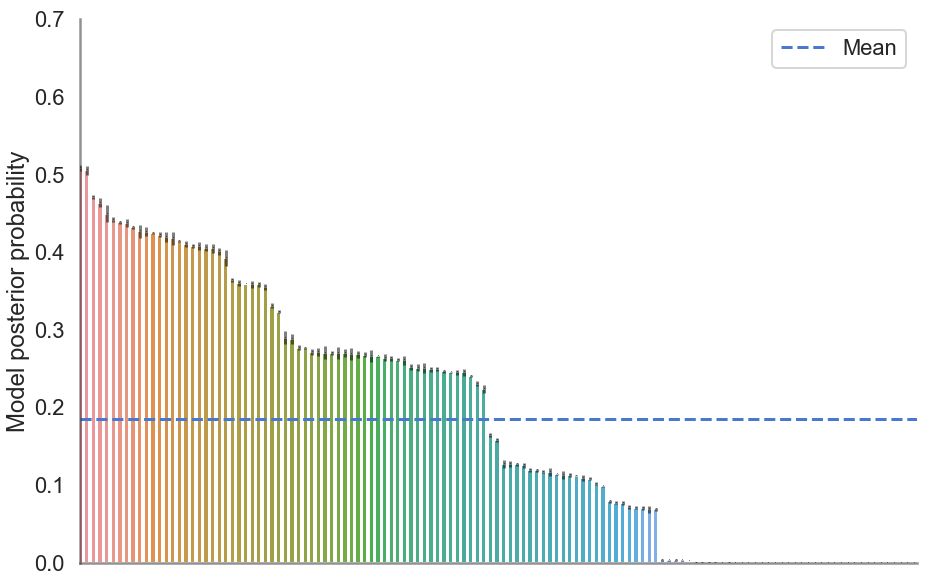

In [40]:
style.use('seaborn-muted')

sub_model_report = model_space_report_df.loc[model_space_report_df['acceptance_ratio']]

model_space_report_df = model_space_report_df.sort_values(by='acceptance_ratio', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()
# Add error bars
sns.set_style("white")
sns.set_context("poster")
data_utils.generate_replicates_and_std(joint_df, model_space_report_df, 3)

ax.errorbar(model_space_report_df.index, 
            model_space_report_df['acceptance_ratio'], 
            yerr=model_space_report_df['stdev'], fmt=',', color='black', alpha=0.5, label=None)

sns.barplot(model_space_report_df.index, model_space_report_df.acceptance_ratio, 
                 data=model_space_report_df, alpha=1, ax=ax)

mean = np.mean(model_space_report_df['acceptance_ratio'].values)
ax.axhline(mean, ls='--', label='Mean')

ax.set(xticklabels=[])
ax.set(ylabel='Model posterior probability')
ax.set(xlabel='')
ax.set(xlim=(0,None))
ax.set(ylim=(0,0.7))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend()
ax.spines["left"].set_alpha(0.5)
ax.spines["bottom"].set_alpha(0.5)

plt.savefig(output_dir + "posterior_probability.pdf", dpi=500)


In [39]:
print(model_space_report_df[['num_parts', 'model_idx']])

     num_parts  model_idx
0          4.0         93
1          5.0          5
2          3.0         44
3          4.0         13
4          4.0         67
5          6.0         27
6          5.0         73
7          5.0         29
8          2.0         79
9          4.0        121
10         3.0         77
11         2.0        123
12         4.0         95
13         5.0          7
14         3.0        119
15         5.0        101
16         3.0         69
17         4.0        103
18         5.0         31
19         4.0         33
20         4.0         75
21         3.0         46
22         4.0         15
23         3.0        107
24         4.0         40
25         4.0        111
26         5.0         48
27         5.0         89
28         6.0          1
29         5.0          9
..         ...        ...
97         5.0         37
98         5.0         84
99         3.0        115
100        5.0         96
101        4.0         85
102        3.0         82
103        4

[Text(0.5, 0, 'Bayes factor')]

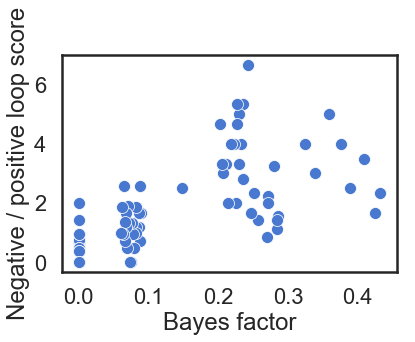

In [10]:
ax = sns.scatterplot(x='acceptance_ratio', y='loop_count_ratio', data=model_space_report_df)
ax.set(ylabel = 'Negative / positive loop score')
ax.set(xlabel = 'Bayes factor')


[Text(0.5, 0, 'Bayes factor')]

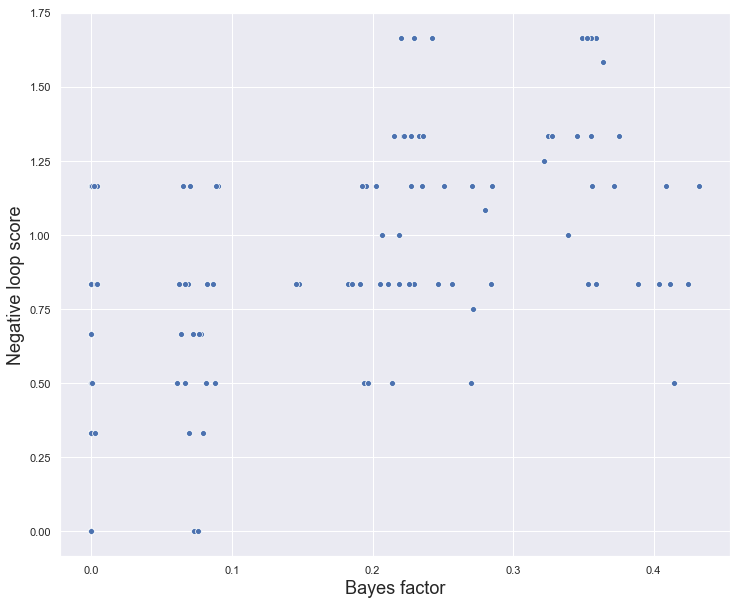

In [15]:
ax = sns.scatterplot(x='acceptance_ratio', y='neg_loop_count', data=model_space_report_df)
ax.set(ylabel = 'Negative loop score')
ax.set(xlabel = 'Bayes factor')


[Text(0.5, 0, 'Bayes factor')]

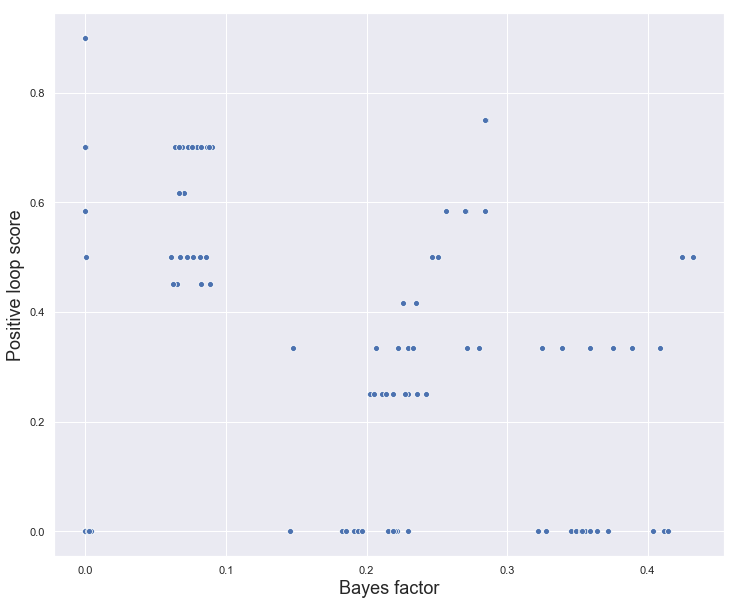

In [16]:
ax = sns.scatterplot(x='acceptance_ratio', y='pos_loop_count', data=model_space_report_df)
ax.set(ylabel = 'Positive loop score')
ax.set(xlabel = 'Bayes factor')
